# Functions

In [ ]:
def split_data(data, labels, test_size):
    #X_train, X_test, Y_train, Y_test = 
    return train_test_split(data, labels, test_size=test_size)

def fit_model(model, train_data, test_data, train_labels, test_labels):
    model.fit(train_data, train_labels)
    predictions = model.predict(test_data)
    acc = metrics.accuracy_score(test_labels, predictions)
    f1 = metrics.f1_score(test_labels, predictions)
    return acc, f1
    
def create_no_labels(train_data, test_data, train_labels, test_labels):
    # create "no label" for unlabeled data (-1==unlabeled)
    unlabeled = np.ones(len(test_labels))*(-1)
    # recombine training dataset labels
    data = np.concatenate((train_data, test_data))
    labels = np.concatenate((train_labels, unlabeled))
    return data, labels

# Imports

In [ ]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.semi_supervised import LabelPropagation
import warnings
warnings.filterwarnings("ignore")

# Upload dataset

# Main

In [14]:
df = pd.read_csv('creditcard.csv')
df.drop(columns=['Time', 'Amount'], inplace=True)

# Oversampling the inferior class with more than 10% 
# of the superior class size. With enough random sample
#size we are guaranteed that we keep as good an approximation
# as of the original distribution.

c = df[df.Class==0].sample(100*(df.Class==1).sum())
f = df[df.Class==1]
final_df = shuffle(pd.concat([c,f], ignore_index=True))
data = final_df.iloc[:,:-1]
labels = final_df.Class
oversample = SMOTE()
data, labels = oversample.fit_resample(data, labels)
accuracy_tab = np.array([])
f1_tab = np.array([])
total_iter = 100

In [28]:
for i in range(0, total_iter):
    X_train, X_test, Y_train, Y_test = split_data(data.to_numpy(), labels.to_numpy(), 0.2)
    X_train_lab, X_train_unlab, Y_train_lab, Y_train_unlab = split_data(X_train, Y_train, 0.7)

    # 2. Train your baseline model on the labeled train set X train lab, and test it on the test set X test.
    # acc1, f1_1 = fit_model(label_model_1, X_train, X_test, Y_train, Y_test)
    label_model_1 = LogisticRegression()
    acc1, f1_1 = fit_model(label_model_1, X_train_lab, X_test, Y_train_lab, Y_test)

    # 3 Train a semi-supervised model (e.g., LabelPropagation based on knn) on both labeled X train lab
    # and unlabeled X train unlab train sets, and test it on the test set X test.
    mixed_data, mixed_labels = create_no_labels(X_train_lab, X_train_unlab, Y_train_lab, Y_train_unlab)
    unlabeled_model = LabelPropagation('knn')
    acc2, f1_2 = fit_model(unlabeled_model, mixed_data, X_test, mixed_labels, Y_test)


    # 4. Get the labels of the previous model(e.g., using model.transduction in python) and train your
    # baseline model on the complete dataset X train along with the obtained labels from the previous
    # model. Finally, test your model on the test set X test.
    #Export labels
    given_labels = unlabeled_model.transduction_
    label_model_2 = LogisticRegression()
    acc3, f1_3 = fit_model(label_model_2, mixed_data, X_test, given_labels, Y_test)

    accuracy_tab = np.append(accuracy_tab, np.array([acc1, acc2, acc3])).reshape(i+1, 3)
    f1_tab = np.append(f1_tab, np.array([f1_1, f1_2, f1_3])).reshape(i+1, 3)

# Plot accuracy over iterations

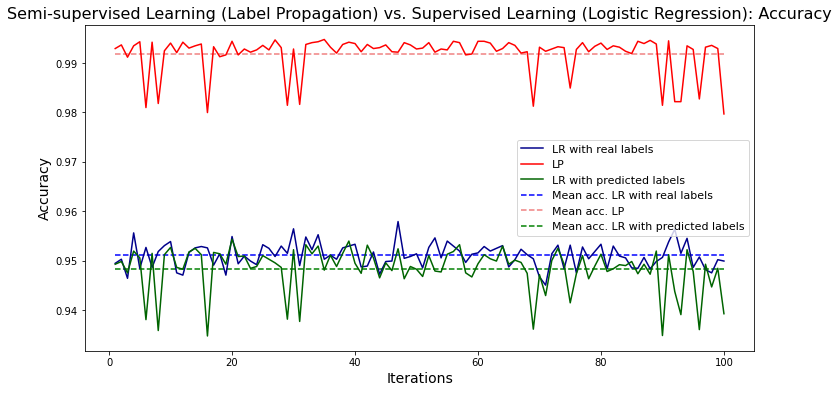

In [58]:

print_1 = [i[0] for i in (accuracy_tab)]
print_2 = [i[1] for i in (accuracy_tab)]
print_3 = [i[2] for i in (accuracy_tab)]
iters = len(accuracy_tab)
plt.figure(figsize=(12,6))
plt.plot(range(1,iters+1), print_1, label = 'LR with real labels', color = 'darkblue')
plt.plot(range(1,iters+1), print_2, label = 'LP', color = 'red')
plt.plot(range(1,iters+1), print_3, label = 'LR with predicted labels', color = 'darkgreen')
plt.xlabel('Iterations', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Semi-supervised Learning (Label Propagation) vs. Supervised Learning (Logistic Regression): Accuracy', fontsize=16)
plt.hlines(np.mean(print_1), 1, 100, linestyles='dashed', label = 'Mean acc. LR with real labels', colors='blue')
plt.hlines(np.mean(print_2), 1, 100, linestyles='dashed', label = 'Mean acc. LP', colors='lightcoral')
plt.hlines(np.mean(print_3), 1, 100, linestyles='dashed', label = 'Mean acc. LR with predicted labels', colors='green')
plt.legend(fontsize=11)

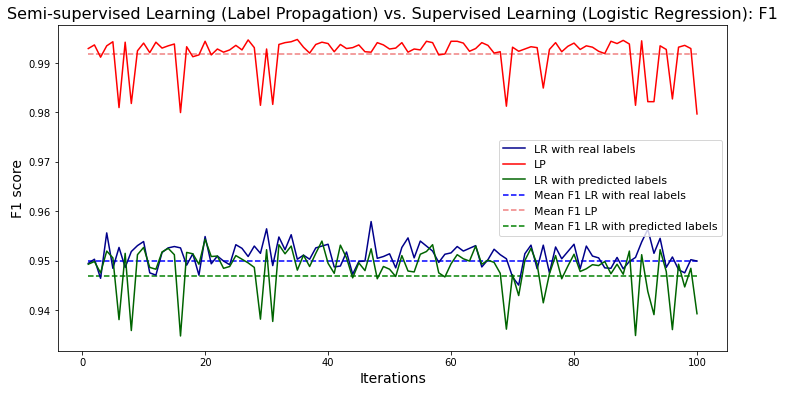

In [60]:
print_1_f = [i[0] for i in (f1_tab)]
print_2_f = [i[1] for i in (f1_tab)]
print_3_f = [i[2] for i in (f1_tab)]
iters = len(f1_tab)
plt.figure(figsize=(12,6))
plt.plot(range(1,iters+1), print_1, label = 'LR with real labels', color = 'darkblue')
plt.plot(range(1,iters+1), print_2, label = 'LP', color = 'red')
plt.plot(range(1,iters+1), print_3, label = 'LR with predicted labels', color = 'darkgreen')
plt.xlabel('Iterations', fontsize=14)
plt.ylabel('F1 score', fontsize=14)
plt.title('Semi-supervised Learning (Label Propagation) vs. Supervised Learning (Logistic Regression): F1', fontsize=16)
plt.hlines(np.mean(print_1_f), 1, 100, linestyles='dashed', label = 'Mean F1 LR with real labels', colors='blue')
plt.hlines(np.mean(print_2_f), 1, 100, linestyles='dashed', label = 'Mean F1 LP', colors='lightcoral')
plt.hlines(np.mean(print_3_f), 1, 100, linestyles='dashed', label = 'Mean F1 LR with predicted labels', colors='green')
plt.legend(fontsize=11)

In [61]:
print(f"Supervised average accuracy with labeled data: {np.mean(print_1)} with {np.std(print_1)} \n"\
      f"Semi-supervised average accuracy: {np.mean(print_2)} with {np.std(print_2)} \n"\
      f"Supervised average accuracy with predicted labels: {np.mean(print_3)} with {np.std(print_3)}")

# pint the standard devaition


Supervised average accuracy with labeled data: 0.9510670955882354 with 0.0023957747809842714 
Semi-supervised average accuracy: 0.9918354779411765 with 0.003863970041661967 
Supervised average accuracy with predicted labels: 0.948344669117647 with 0.004435987710014253


In [62]:
print(f"Supervised with labeled dataaverage f1 metrc: {np.mean([i[0] for i in (f1_tab)])} with {np.std([i[0] for i in (f1_tab)])}\n"\
      f"Semi-supervised average f1 metric: {np.mean([i[1] for i in (f1_tab)])} with {np.std ([i[1] for i in (f1_tab)])}\n"\
      f"Supervised with predicted labels average f1 metric: {np.mean([i[2] for i in (f1_tab)])} with {np.std([i[2] for i in (f1_tab)])}")


Supervised with labeled dataaverage f1 metrc: 0.9498178902356007 with 0.0025962294222073765
Semi-supervised average f1 metric: 0.9918501744987147 with 0.003913710034799079
Supervised with predicted labels average f1 metric: 0.9468993344093615 with 0.004877917862848474


In [38]:
np.savetxt("Supervised_Accuracies_lab3.txt", print_1, fmt="%s")
np.savetxt("Semi-upervised_Accuracies3.txt", print_2, fmt="%s")
np.savetxt("Supervised_Accuracies_pred3.txt", print_3, fmt="%s")

np.savetxt("Supervised_f1_lab3.txt", [i[0] for i in (f1_tab)], fmt="%s")
np.savetxt("Semi-upervised_f13.txt", [i[1] for i in (f1_tab)], fmt="%s")
np.savetxt("Supervised_f1_pred3.txt", [i[2] for i in (f1_tab)], fmt="%s")